In [1]:
X= 88.386950
Y= 22.476530

In [2]:
import re, os, collections, itertools, uuid, logging
import scipy as sp
import collections
collections.Callable = collections.abc.Callable
from datetime import date
import arrow
import pyproj
import geopandas
import imageio
from PIL import Image
from fastai.basics import *
import joblib
from io import FileIO
import numpy
import pandas as pd
from ipywidgets import widgets
from IPython.display import display

In [4]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AdQt8qj_KDsl8glEVEdHdBBMt823xXEcuGD_sKyze7pLKEgQuzHZzh7em-c

Successfully saved authorization token.


In [4]:
helper_dir = str(Path('https://github.com/Cowwl/Sat-Based-Leak-Detecion/tree/main/data').absolute())
if helper_dir not in os.sys.path:
    os.sys.path.append(helper_dir)
    
from leak_helpers.earth_engine import display_ee, bands_s2, download_image, bands_s2, bands_s1, bands_l7, bands_l8

ModuleNotFoundError: No module named 'leak_helpers'

In [7]:
today = date.today()
repo_date_ts = arrow.get(today)
chec_date = repo_date_ts.shift(weeks=-24)
repo_date_ts = repo_date_ts.format('YYYY-MM-DD')
chec_date = chec_date.format('YYYY-MM-DD')
print(chec_date)

2022-01-29


In [5]:
crs_grid = 3857
notebook_name='testing_earth_engine-l7-AUTX'
ts=arrow.utcnow().format('YYYYMMDD-HH-mm-ss')
data_dir = Path('https://github.com/Cowwl/Sat-Based-Leak-Detecion/tree/main/data')
bands = bands_l7

# since the lowest res band is 60m and I want to capture neighbours I should get 6+ pixels
pixel_length = 400
resolution_min = 200 # m
time_bin_delta = 60*60*24*28 # how long before a leak to look (in seconds)
# TODO get closest but let me filter for time

# init
temp_dir = Path(tempfile.mkdtemp(prefix=notebook_name+'-', suffix='-'+ts))
# output_dir = data_dir.joinpath('{ts:}_{notebook_name:}'.format(ts=ts,notebook_name=notebook_name))
output_dir = Path('https://github.com/Cowwl/Sat-Based-Leak-Detecion/tree/main/data/images')
cache_dir = output_dir.joinpath('ee_l7_AUTX-leaks_cache_v2')

output_dir.mkdir(parents=True, exist_ok=True)
temp_dir.mkdir(parents=True, exist_ok=True)
cache_dir.mkdir(parents=True, exist_ok=True)

logger = logging.getLogger(notebook_name)
logger.setLevel(logging.WARN)

crs_grid_proj = pyproj.Proj('epsg:%s'%crs_grid)

temp_dir, output_dir, cache_dir

distance = resolution_min*(pixel_length/2.0-0.5)
print(distance)

NameError: name 'bands_l7' is not defined

In [9]:
from shapely.geometry import Point

d = {'col1': ['name1'], 'geometry': [Point(X, Y)]}

gdf = geopandas.GeoDataFrame(d, crs=4326)

gdf

,col1,geometry
0,name1,POINT (88.38695 22.47653)


In [10]:
def get_boundary(leak, distance=100, maxError=None):
    """get rectangular around geopandas point"""
    # coords = np.array(leak.geometry.values[0].xy)[:, 0].tolist()
    # geom = ee.Geometry.Point(coords)
    # boundary = ee.Geometry.buffer(geometry=geom, distance=distance, maxError=maxError)
    # rect = boundary.bounds()

    # Here we make a boundary in wgs84 that will make an exact rectangle in
    # epsg 3857 (aux sphere) so we will get a rectangle when we clip the image
    point_aux = np.array(leak.geometry.to_crs(epsg=3857).values[0].xy)[:, 0]
    xMin, yMin, xMax, yMax = point_aux[0] - distance, point_aux[1] - distance, point_aux[0] + distance, point_aux[1] + distance

    # convert to wgs8
    p0 = pyproj.Proj(init='epsg:%s' % 4326)
    p1 = pyproj.Proj(init='epsg:%s' % 3857)
    bound_grid2 = pyproj.transform(p1, p0, [xMin, xMax], [yMin, yMax])
    bound_grid2 = np.array(bound_grid2).T
    [xMin, yMin], [xMax, yMax] = bound_grid2.min(0), bound_grid2.max(0)

    # make into earth engine rec
    rect = ee.Geometry.Rectangle([xMin, yMin, xMax, yMax])
    return rect

In [11]:
boundary = get_boundary(gdf.geometry, distance=distance)
print(boundary)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              88.02852220163629,
              22.807332692389146
            ],
            [
              88.02852220163629,
              22.14493521891918
            ],
            [
              88.74537779836368,
              22.14493521891918
            ],
            [
              88.74537779836368,
              22.807332692389146
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})


C:\Users\anubh\SatProj\venv\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\anubh\SatProj\venv\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\anubh\AppData\Local\Temp\ipykernel_3200\1390111849.py:16: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bo

In [12]:
sentinel2_before = (ee.ImageCollection('LANDSAT/LE07/C02/T1_RT')
        .filterBounds(ee.Geometry.Point(float(X),float(Y)))
        .filterDate(chec_date, repo_date_ts)
        .sort('system:time_start', opt_ascending=False)
       )

In [13]:
image = ee.Image(sentinel2_before.first()).clip(boundary)
print(image.getInfo())

{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [2483, 1810], 'origin': [2825, 0], 'crs': 'EPSG:32645', 'crs_transform': [30, 0, 520785, 0, -30, 2503515]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [2483, 1810], 'origin': [2825, 0], 'crs': 'EPSG:32645', 'crs_transform': [30, 0, 520785, 0, -30, 2503515]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [2483, 1810], 'origin': [2825, 0], 'crs': 'EPSG:32645', 'crs_transform': [30, 0, 520785, 0, -30, 2503515]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [2483, 1810], 'origin': [2825, 0], 'crs': 'EPSG:32645', 'crs_transform': [30, 0, 520785, 0, -30, 2503515]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [2483, 1810], '

In [14]:
def tifs2np(path, files, pixel_length=None, bands=bands_s2):
    """Convert tifs to numpy array"""
    tifs = [f for f in files if f.endswith('.tif')]

    if pixel_length:
        pixel_length = int(pixel_length)

    channels = {}
    for tif in tifs:
        band = tif.split('.')[-2]
        # read tif as float32
        x = imageio.imread(path.joinpath(tif))
        if pixel_length:
            if x.shape[-2] != pixel_length or x.shape[-1] != pixel_length:
                logger.warn('warning had to reshape band %s from %s to %s' % (band, x.shape, pixel_length))
                x = sp.misc.imresize(x, size=(pixel_length, pixel_length), interp='cubic', mode='F')
        channels[band] = x

    if not pixel_length:
        pixel_length = x.shape[1]

    logger.debug('keys %s', (channels.keys()))
    data = []
    for band in bands:
        if band not in channels:
            channels[band] = np.zeros((pixel_length, pixel_length))
        data.append(channels[band])
    return np.array(data)

In [15]:
def download_image(clipped_image, scale=10, crs=4326, name=None, cache_dir=temp_dir, progress_bar=False, report=False):
    """Download image from google earth engine"""

    # TODO add progress bar like https://github.com/fchollet/keras/blob/master/keras/utils/data_utils.py#L103
    path = clipped_image.getDownloadURL({
        'scale': scale,
        'crs': 'EPSG:%s' % crs
    })
    if name is None:
        name = clipped_image.getMapId()['mapid']

    # TODO check that it's not too big, but we don't get given clipped size

    filename = '{name:}_{crs:}_{scale:}'.format(
        name=name, scale=scale, crs=crs)
    zip_dwn_file = temp_dir.joinpath(filename + '.zip')
    if report:
        with tqdm(
                unit='B', unit_scale=True, miniters=1, mininterval=1,
                desc=path.split('/')[-1][:40]) as t:  # all optional kwargs
            zip_dwn_file, r = urllib.request.urlretrieve(
                path, zip_dwn_file, reporthook=my_hook(t))
    else:
        zip_dwn_file, r = urllib.request.urlretrieve(path, zip_dwn_file)
    zip_dwn_file

    # extract
    zfile = zipfile.ZipFile(zip_dwn_file)
    extract_dir = cache_dir.joinpath(filename)
    zfile.extractall(extract_dir)
    #     logger.debug(extract_dir, zip_dwn_file)

    files = [str(f.relpath(extract_dir)) for f in extract_dir.iterdir()]
    logger.debug('Extracted files %s to %s', files, str(extract_dir))
    return extract_dir, files

In [16]:
name='test'
path,files=download_image(
    image, 
    scale=resolution_min, 
    crs=crs_grid, 
    name=name,
    cache_dir=cache_dir
)
data = tifs2np(path,files,bands=bands_l7)

C:\Users\anubh\AppData\Local\Temp\ipykernel_3200\2881063094.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(path.joinpath(tif))


<AxesSubplot:>

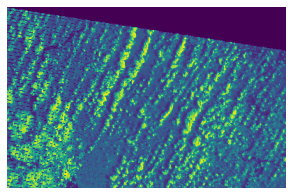

In [17]:
im = Image.open(r"https://github.com/Cowwl/Sat-Based-Leak-Detecion/tree/main/data/images/ee_l7_AUTX-leaks_cache_v2/test_3857_200/LE07_138045_20220404.B5.tif") 
show_image(im)

In [18]:
newpath = Path('https://github.com/Cowwl/Sat-Based-Leak-Detecion/tree/main/data/export.pkl').absolute()
newerpath= Path('https://github.com/Cowwl/Sat-Based-Leak-Detecion/tree/main/data/images/ee_l7_AUTX-leaks_cache_v2/test_3857_200/LE07_138045_20220404.B5.tif').absolute()

In [23]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [24]:
learn_inf = load_learner(newpath)

In [25]:
pred,pred_idx,probs = learn_inf.predict(newerpath)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: false; Probability: 0.6264')